This notebook walks through how to access hyperspectral remote sensing reflectance (Rrs) data from NASA's PACE satellite, use that Rrs data to estimate pigment concentrations (chlorophyll a, chlorophyll b, chlorophyll c, and photoprotective carotenoids (PPC)), and then plot the pigment concentratiosn using a color map with latitude and longitude coordinates. 

You need an Earthdata account to access PACE data. You can create an account here: https://urs.earthdata.nasa.gov
See part one (Setup) and two (NASA Earthdata Authentication) on this tutorial: https://oceancolor.gsfc.nasa.gov/resources/docs/tutorials/notebooks/oci_data_access/

In [1]:
import earthaccess

/glusteruser/awindled/pace-rrs-inversions-pigments/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
auth = earthaccess.login(persist=True)

Next, import L3_utils. L3_utils contains methods to retrieve level 3 PACE Rrs data, apply the inversion method to estimate pigment concentrations, and then plot the pigments. 

In [3]:
from gpig import L3_utils

First download Rrs, salinity, and temperature data by calling L3_utils.load_data(). The time span is passed in as a tuple of strings with the format 'YYYY-MM-DD'. The resolution is passed in as a string. The only resolutions availble are '1deg', '0p1deg', and '4km'. The data files are in nc format and are saved to folders called 'rrs_data', 'sal_data', and 'temp_data'. The method returns three lists: the first contains file paths to Rrs data, the second contains file paths to salinity data, and the third contains file paths to temperature data.

In [4]:
# download Rrs, salinity, and temp data from 2024-06-12 to 2024-06-15 at 4km resolution
rrs_paths, sal_paths, temp_paths = L3_utils.load_data(('2024-06-12','2024-06-15'), '4km')

QUEUEING TASKS | : 100%|██████████| 4/4 [00:00<00:00, 1502.66it/s]
PROCESSING TASKS | : 100%|██████████| 4/4 [00:18<00:00,  4.54s/it]
COLLECTING RESULTS | : 100%|██████████| 4/4 [00:00<00:00, 34450.14it/s]
QUEUEING TASKS | : 100%|██████████| 12/12 [00:00<00:00, 2225.09it/s]
PROCESSING TASKS | : 100%|██████████| 12/12 [00:10<00:00,  1.17it/s]
COLLECTING RESULTS | : 100%|██████████| 12/12 [00:00<00:00, 72315.59it/s]
QUEUEING TASKS | : 100%|██████████| 5/5 [00:00<00:00, 611.47it/s]
PROCESSING TASKS | : 100%|██████████| 5/5 [00:17<00:00,  3.58s/it]
COLLECTING RESULTS | : 100%|██████████| 5/5 [00:00<00:00, 31631.25it/s]


In [5]:
rrs_paths

['rrs_data/PACE_OCI.20240612.L3m.DAY.RRS.V3_0.Rrs.4km.nc',
 'rrs_data/PACE_OCI.20240613.L3m.DAY.RRS.V3_0.Rrs.4km.nc',
 'rrs_data/PACE_OCI.20240614.L3m.DAY.RRS.V3_0.Rrs.4km.nc',
 'rrs_data/PACE_OCI.20240615.L3m.DAY.RRS.V3_0.Rrs.4km.nc']

In [6]:
# salinity data files are kept as 8 day averages, so some files are dated before/after the date range and are downloaded as well
sal_paths

['sal_data/SMAP_L3_SSS_20240608_8DAYS_V5.0.nc',
 'sal_data/SMAP_L3_SSS_20240609_8DAYS_V5.0.nc',
 'sal_data/SMAP_L3_SSS_20240610_8DAYS_V5.0.nc',
 'sal_data/SMAP_L3_SSS_20240611_8DAYS_V5.0.nc',
 'sal_data/SMAP_L3_SSS_20240612_8DAYS_V5.0.nc',
 'sal_data/SMAP_L3_SSS_20240613_8DAYS_V5.0.nc',
 'sal_data/SMAP_L3_SSS_20240614_8DAYS_V5.0.nc',
 'sal_data/SMAP_L3_SSS_20240615_8DAYS_V5.0.nc',
 'sal_data/SMAP_L3_SSS_20240616_8DAYS_V5.0.nc',
 'sal_data/SMAP_L3_SSS_20240617_8DAYS_V5.0.nc',
 'sal_data/SMAP_L3_SSS_20240618_8DAYS_V5.0.nc',
 'sal_data/SMAP_L3_SSS_20240619_8DAYS_V5.0.nc']

In [7]:
temp_paths

['temp_data/20240612090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'temp_data/20240613090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'temp_data/20240614090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'temp_data/20240615090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc',
 'temp_data/20240616090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc']

After downloading the files you can pass in the files along with a bounding box into the estimate_inv_pigments method to run the inversion algorithm. The bounding box is a tuple of 4 ints/floats of the form (lower_left_lon, lower_left_lat, upper_left_lon, upper_left_lat) that represents the area you want to estimate pigments for. You can either pass in a single file path as a string to estimate pigment concentrations for that specific day, or you can pass in the list of file paths to get a date averaged estimation of pigment concentrations. 
This method will return an xarray dataset with pigment values for chla, chlb, chlc, and ppc. This calculates the pigment values for each coordinate in the dataset. Calculating the pigments can take a long time; the number of pixels calculated and the total number of pixels is displayed.

In [8]:
rrs_paths[0]

'rrs_data/PACE_OCI.20240612.L3m.DAY.RRS.V3_0.Rrs.4km.nc'

In [9]:
sal_paths[4]

'sal_data/SMAP_L3_SSS_20240612_8DAYS_V5.0.nc'

In [10]:
temp_paths[0]

'temp_data/20240612090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc'

In [11]:
# This calculates pigments using Rrs, salinity, and temperature on 2024-06-12 from 49N to 47N, and -125W to -124W, an area
# off the coast of Washington. 
bbox = (-125, 47, -124, 49)
pigments = L3_utils.estimate_inv_pigments(rrs_paths[0], sal_paths[4], temp_paths[0], bbox)
pigments

ValueError: rrs_paths must be a string or a list containing at least one filepath

After the pigments have downloaded, it is a good idea to save the pigment dataset to an nc file so you don't have to compute the pigment values again. 

In [14]:
import xarray
pigments.to_netcdf('pigments/wash_coast')

You can open the data file again when you need it

In [15]:
pigments = xarray.open_dataset('pigments/wash_coast')
pigments

<xarray.Dataset> Size: 37kB
Dimensions:  (lat: 48, lon: 24)
Coordinates:
  * lat      (lat) float32 192B 48.98 48.94 48.9 48.85 ... 47.1 47.06 47.02
  * lon      (lon) float32 96B -125.0 -124.9 -124.9 ... -124.1 -124.1 -124.0
Data variables:
    chla     (lat, lon) float64 9kB ...
    chlb     (lat, lon) float64 9kB ...
    chlc     (lat, lon) float64 9kB ...
    ppc      (lat, lon) float64 9kB ...

Now use plot_pigments method to plot a map of pigment values. Pigment values are in units of mg/m^3. 

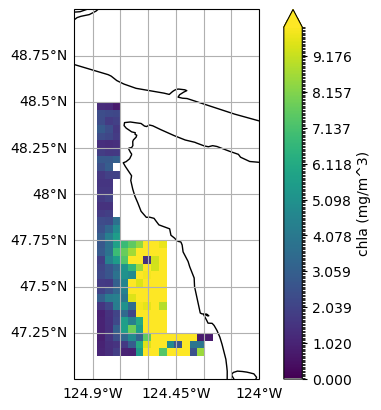

In [17]:
# This plots the concentration of chlorophyll a on a color map. The color bar is set to show values from 0 to 10 with a label
# 'chla (mg/m^3)'
chla = pigments['chla']
L3_utils.plot_pigments(pigments['chla'], 0, 10, 'chla (mg/m^3)')

In [18]:
#Use average Rrs, salinity, and temperature values from 2024-06-12 to 2024-06-15 to estimate pigments for the same area as above.
bbox = (-125, 47, -124, 49)
avg_pigments = L3_utils.estimate_inv_pigments(rrs_paths, sal_paths, temp_paths, bbox)
avg_pigments.to_netcdf('pigments/wash_coast_avg')
avg_pigments

num pixels:  1152
Progress: 1152/1152

<xarray.Dataset> Size: 37kB
Dimensions:  (lat: 48, lon: 24)
Coordinates:
  * lat      (lat) float32 192B 48.98 48.94 48.9 48.85 ... 47.1 47.06 47.02
  * lon      (lon) float32 96B -125.0 -124.9 -124.9 ... -124.1 -124.1 -124.0
Data variables:
    chla     (lat, lon) float64 9kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    chlb     (lat, lon) float64 9kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    chlc     (lat, lon) float64 9kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ppc      (lat, lon) float64 9kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

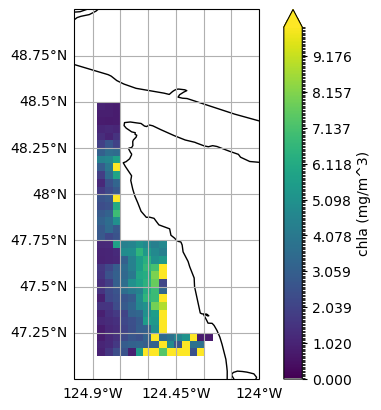

In [28]:
# Notice the difference in this plot of a 4 day average compared to the plot of a single day. 
chla = avg_pigments['chla']
L3_utils.plot_pigments(avg_chla, 0, 10, 'chla (mg/m^3)')

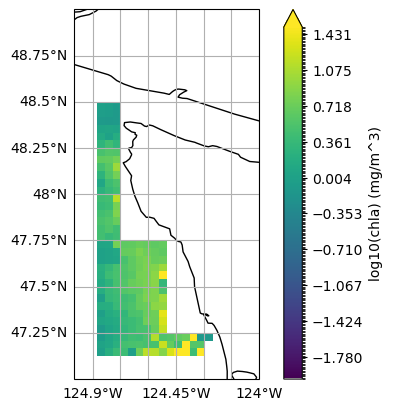

In [29]:
# plot chlorophyll a on a log 10 scale to emphasize variation. Note how the scale of the color bar is now -2 to 1.5
import numpy as np
log_chla = np.log10(chla)
L3_utils.plot_pigments(log_chla, -2, 1.5, 'log10(chla) (mg/m^3)')

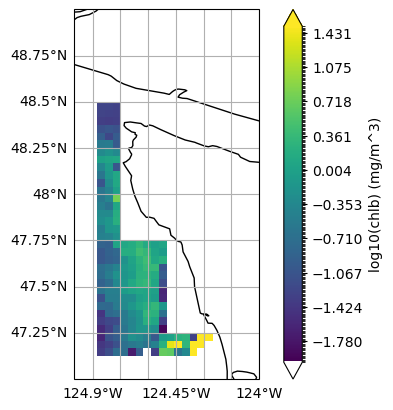

In [30]:
# plot chlorophyll b on a log 10 scale
chlb = avg_pigments['chlb']
log_chlb = np.log10(chlb)
L3_utils.plot_pigments(log_chlb, -2, 1.5, 'log10(chlb) (mg/m^3)')

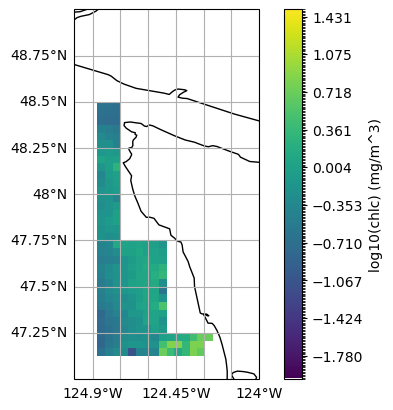

In [31]:
# plot chlorophyll c on a log 10 scale
chlc = avg_pigments['chlc']
log_chlc = np.log10(chlc)
L3_utils.plot_pigments(log_chlc, -2, 1.5, 'log10(chlc) (mg/m^3)')

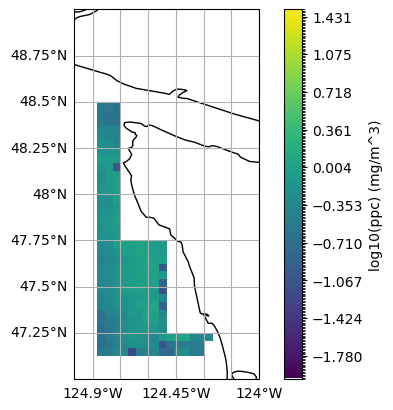

In [32]:
# plot PPC on a log 10 scale
ppc = avg_pigments['ppc']
log_ppc = np.log10(ppc)
L3_utils.plot_pigments(log_ppc, -2, 1.5, 'log10(ppc) (mg/m^3)')

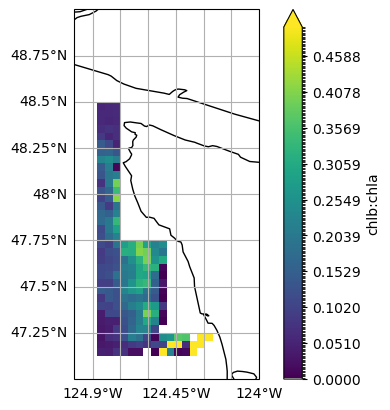

In [33]:
# plot the ratio between chlb and chla
ba_ratio = chlb/avg_chla
L3_utils.plot_pigments(ba_ratio, 0, 0.5, 'chlb:chla')

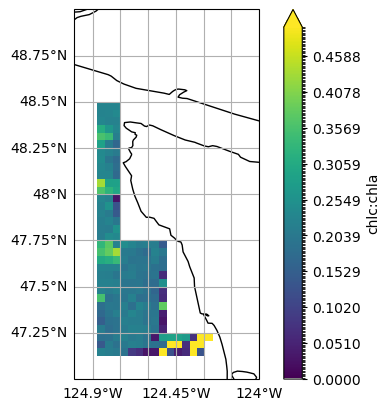

In [34]:
# plot the ratio between chlc and chla
ca_ratio = chlc/chla
L3_utils.plot_pigments(ca_ratio, 0, 0.5, 'chlc:chla')

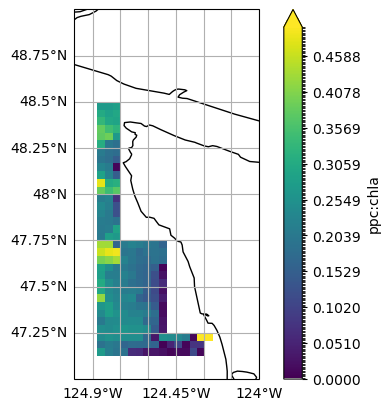

In [35]:
# plot the ratio between ppc and chla
pa_ratio = ppc/chla
L3_utils.plot_pigments(pa_ratio, 0, 0.5, 'ppc:chla')